In [ ]:
# Problem: Generating Handwritten Digits

Imagine you want to create a system that can generate realistic handwritten digits, similar to what you see in numbers written by humans. You want the system to learn the patterns and variations present in different handwritten digits and then be able to generate new digit images that look like handwritten numbers.

In [1]:
import torch
from torchvision import transforms as T
from torchvision import datasets
import torchvision.models as models
from torch import nn, optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# 1. Download 
import torchvision

classes = tuple(str(i) for i in range(10))

def get_dataloaders(batch_size=4):

  # Load dataset 
  transform = T.Compose([T.ToTensor(), 
                         T.Normalize((0.1307,), (0.3081,))])

  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
  return trainloader, testloader

trainloader, testloader = get_dataloaders(batch_size=4)


In [6]:
28*28

784

In [3]:
class LinearVAE(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, latent_size=64):
        super(LinearVAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_size, latent_size)  # Mean of latent space
        self.fc_logvar = nn.Linear(hidden_size, latent_size)  # Log variance of latent space

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid(),
        )

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        output = self.decoder(z)
        return output

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z)
        return output, mu, logvar

In [4]:
# Define loss funstions 
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = LinearVAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [7]:
# 3. Train loop
from tqdm import tqdm_notebook
import numpy as np

def fit(epochs, net, loss_fn, optimizer, train_dl, val_dl):

  train_losses = []
  val_losses = []

  flatten = nn.Flatten()

  for epoch in tqdm_notebook(range(epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_dl:
        x_batch, y_batch = batch

        optimizer.zero_grad()
        #a = flatten(x_batch)
        #b = x_batch.view(x_batch.size(0), -1)

        reconstruction, mu, logsigma = autoencoder(x_batch.view(x_batch.size(0), -1).to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(x_batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_dl:
          x_batch, y_batch = batch
          reconstruction, mu, logsigma = autoencoder(x_batch.view(x_batch.size(0), -1).to(device))
          #print(reconstruction.shape)

          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(x_batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  return train_losses,val_losses 


In [8]:
epochs = 2 #50
#output with shape [1, 28, 28] doesn't match the broadcast shape [3, 28, 28]
train_losses,val_losses = fit(epochs, autoencoder, criterion, optimizer, trainloader, testloader)

<ipython-input-7-cb1b968579b8>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs)):


  0%|          | 0/2 [00:00<?, ?it/s]

In [56]:

from matplotlib import pyplot as plt
plt.figure(figsize=(12,9))
plt.subplot(2,1,1)
plt.xlabel('epoch')
plt.plot(train_losses, label='train losses (mean loss for each epoch)')
plt.plot(val_losses, label='val losses')
plt.legend()


"\nfrom matplotlib import pyplot as plt\nplt.figure(figsize=(12,9))\nplt.subplot(2,1,1)\nplt.xlabel('epoch')\nplt.plot(train_losses, label='train losses (mean loss for each epoch)')\nplt.plot(val_losses, label='val losses')\nplt.legend()\n"

In [20]:
len(trainloader)

15000

In [9]:
# 4. Let's see recovered image
autoencoder.eval()
with torch.no_grad():
    for batch in testloader:
      x_batch, y_batch = batch
      #sample = x_batch[0]
      #print(sample.shape)
      reconstruction, mu, logsigma = autoencoder(x_batch.view(x_batch.size(0), -1).to(device))
      reconstruction = reconstruction.view(-1, 28, 28, 1)
      x_batch = x_batch.view(-1, 28, 28, 1)
      result = reconstruction.cpu().detach().numpy()
      ground_truth = x_batch.numpy()
      break

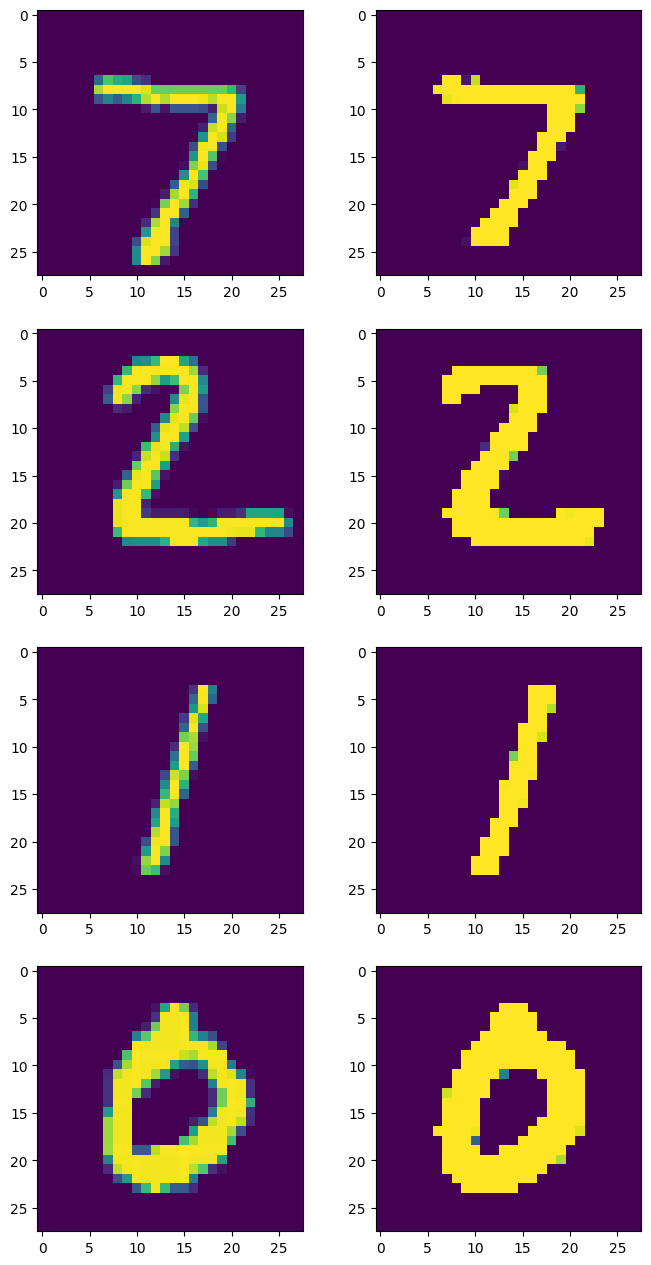

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)